<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
import numpy as np
import torch 
import torch.nn.functional as F
from torch import nn
import scipy.io as io
import matplotlib.pyplot as plt

# from keras.utils import to_categorical
from torch.optim import SGD, Adam
from torch.utils import data

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [2]:

M=4
NN_T = 512
NN_R=256

In [3]:
# a = np.random.randn(1,1000000)/np.sqrt(2)

# a[a>0.9*np.max(np.abs(a))] = 0.9**np.max(np.abs(a))


# counts, bins = np.histogram(a,1000)
# plt.hist(bins[:-1], bins, weights=counts)

In [4]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(M**2 + 8, NN_T) 
        self.bn1 = nn.BatchNorm1d(NN_T)
        
        self.fc2 = nn.Linear(NN_T, NN_T)
        self.bn2 = nn.BatchNorm1d(NN_T)
        self.fc3 = nn.Linear(NN_T, 4)
        
    def forward(self, in_message, in_channel):
        x = torch.cat([in_message,in_channel],-1)
        x = self.bn1(F.relu(self.fc1(x)))
        x = self.bn2(F.relu(self.fc2(x)))
        x = self.fc3(x)
        transmitted = x / (torch.sqrt(2*torch.mean(x**2)))
        return transmitted
        
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.de_fc1 = nn.Linear(2 + 4, NN_R)  
        self.bn1 = nn.BatchNorm1d(NN_R)
        
        self.de_fc2 = nn.Linear(NN_R, NN_R)
        self.bn2 = nn.BatchNorm1d(NN_R)
        
        self.de_fc3 = nn.Linear(NN_R, NN_R)
        self.bn3 = nn.BatchNorm1d(NN_R)
        
        self.de_fc4 = nn.Linear(NN_R, M)
        self.bn4 = nn.BatchNorm1d(M)
    def forward(self, in_message, in_channel):
        x = torch.cat([in_message,in_channel],-1)
#         x = in_message
        x = self.bn1(F.relu(self.de_fc1(x)))
        x = self.bn2(F.relu(self.de_fc2(x)))
        x = self.bn3(F.relu(self.de_fc3(x)))
#         x = self.de_fc4(x)
        x = self.bn4(self.de_fc4(x))
        decoded = F.log_softmax(x, dim=-1)
        return decoded
        
        
        


In [5]:


encoder = Encoder().to(device)

decoder1=Decoder().to(device)
decoder2=Decoder().to(device)
criterion= nn.NLLLoss()

params = list(encoder.parameters()) + list(decoder1.parameters())+ list(decoder2.parameters())


opt = Adam(params, lr = 0.001)

loss = np.array([])

batch = M * 6400000
ch_real_set = torch.randn((batch, 2,2))/np.sqrt(2)
ch_imag_set = torch.randn((batch, 2,2))/np.sqrt(2)



ch_set = data.TensorDataset(ch_real_set, ch_imag_set)
training_generator= data.DataLoader(ch_set, batch_size=2048, shuffle=True, num_workers=4)

for epochs in range(20):
    print('epoch=', epochs)
    for csi_real,csi_imag in training_generator:
        csi_real = csi_real.to(device)
        csi_imag = csi_imag.to(device)
        csi = torch.cat([csi_real.view(-1,4), csi_imag.view(-1,4)], -1)
        csi1 = torch.cat([csi[:,0:2], csi[:,4:6]], -1)
        csi2 = torch.cat([csi[:,2:4], csi[:,6:8]], -1)
        
        label1 = np.random.randint(0,M, (csi.shape[0]))
        label2 = np.random.randint(0,M, (csi.shape[0]))
        
        
        train_data = 4*label1 + label2
        
        train_data = F.one_hot(torch.from_numpy(train_data)).float().to(device)
      
    
        
        label1 = torch.from_numpy(label1).to(device)
        label2 = torch.from_numpy(label2).to(device)
        
    
       
        transmitted =encoder(train_data, csi)
        
        
        transmitted_real = transmitted[:, np.arange(0,2)]
        transmitted_imag = transmitted[:, np.arange(2,4)]
        
        tx_real = transmitted_real.view(-1, 2,1)
        tx_imag = transmitted_imag.view(-1, 2,1)
       

        rx_real = torch.bmm(csi_real, tx_real) - torch.bmm(csi_imag, tx_imag)
        rx_imag = torch.bmm(csi_real, tx_imag) + torch.bmm(csi_imag, tx_real)
       
        rx1 = torch.cat([rx_real[:,0,:], rx_imag[:,0,:]], axis=-1)
       
        rx2 = torch.cat([rx_real[:,1,:], rx_imag[:,1,:]], axis=-1)
      
        
        sigma = np.sqrt(0.5/np.power(10, 15/10))
        rx1 = rx1 + (torch.randn(rx1.shape)*sigma).to(device)
  
        rx2 = rx2 + (torch.randn(rx2.shape)*sigma).to(device)
    

        y_pred1 = decoder1(rx1, csi1)
        y_pred2 = decoder2(rx2, csi2)
       
        
        cross_entropy = criterion(y_pred1, label1) + criterion(y_pred2, label2)

        opt.zero_grad()
        
        
        cross_entropy.backward()
        opt.step()
        

        l = cross_entropy.item()
        loss = np.append(loss, l)
    

epoch= 0
epoch= 1
epoch= 2
epoch= 3
epoch= 4
epoch= 5
epoch= 6
epoch= 7
epoch= 8
epoch= 9
epoch= 10
epoch= 11
epoch= 12
epoch= 13
epoch= 14
epoch= 15
epoch= 16
epoch= 17
epoch= 18
epoch= 19


In [6]:
print(loss.shape)

(250000,)


[ 1  2  3  4  5  6  7  8  9 10]
(2500,)


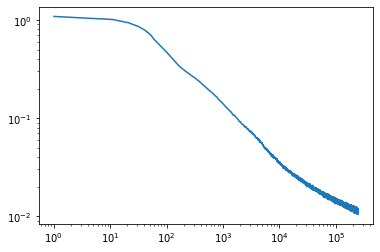

In [46]:
from scipy.ndimage.filters import gaussian_filter1d
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter 
import tikzplotlib


qqq = loss
# ysmoothed = gaussian_filter1d(qqq, sigma=0.1)


# plt.figure()
# plt.loglog(loss)

aaa = savgol_filter(qqq,101,1)


x = np.arange(1,qqq.shape[0]+1)
print(x[0:10])
# plt.loglog(x,aaa)


data = np.concatenate([x.reshape(-1,1), aaa.reshape(-1,1)], -1)
plt.loglog(data[::10,0],data[::10,1]/2)

print(data[::100,0].shape)



np.savetxt('mu_mimo_loss.txt', data[::100,:])



In [53]:
torch.cuda.empty_cache()
SER =np.array([])
num_iter=1
with torch.no_grad():
    for snr in np.arange(0, 40,1):
        torch.cuda.empty_cache()
        
        batch = M * 16*10000
        
        ch_real = ((torch.randn((batch, 2,2))/np.sqrt(2))).to(device)
        ch_imag = ((torch.randn((batch, 2,2))/np.sqrt(2))).to(device)

        total_corr = 0
        for i in range(num_iter):
            test_messages = np.arange(M)
            test_messages = np.tile(test_messages, int(batch/M))

            test_mess1 = np.random.permutation(test_messages)
            test_mess2 = np.random.permutation(test_messages)


            csi = torch.cat([ch_real.view(-1,4), ch_imag.view(-1,4)], -1).to(device)
            csi1 = torch.cat([csi[:,0:2], csi[:,4:6]], -1).to(device)
            csi2 = torch.cat([csi[:,2:4], csi[:,6:8]], -1).to(device)


            test_data = 4*test_mess1 + test_mess2
            test_data_set= F.one_hot(torch.from_numpy(test_data)).float().to(device)




            transmitted =encoder(test_data_set, csi)

            transmitted_real = transmitted[:, np.arange(0,2)]
            transmitted_imag = transmitted[:, np.arange(2,4)]

            tx_real = transmitted_real.view(-1, 2,1)
            tx_imag = transmitted_imag.view(-1, 2,1)

            rx_real = torch.bmm(ch_real, tx_real) - torch.bmm(ch_imag, tx_imag)
            rx_imag = torch.bmm(ch_real, tx_imag) + torch.bmm(ch_imag, tx_real)

            rx1 = torch.cat([rx_real[:,0,:], rx_imag[:,0,:]], axis=-1)
            rx2 = torch.cat([rx_real[:,1,:], rx_imag[:,1,:]], axis=-1)

            sigma = np.sqrt(0.5/np.power(10, snr/10))
            rx1 = rx1 + (torch.randn(rx1.shape)*sigma).to(device)
            rx2 = rx2 + (torch.randn(rx2.shape)*sigma).to(device)

            y_pred1 = decoder1(rx1, csi1)
            y_pred2 = decoder2(rx2, csi2)


            classification1 = torch.argmax(y_pred1, axis=-1).to('cpu').detach().numpy()
            classification2 = torch.argmax(y_pred2, axis=-1).to('cpu').detach().numpy()

            correct1 = np.equal(classification1 , test_mess1)
            correct2 = np.equal(classification2 , test_mess2)
            correct = sum(correct1) + sum(correct2)
          
            total_corr = total_corr + correct
        ser =1 - total_corr / (batch*2*num_iter)

        SER = np.append(SER, ser)


In [54]:
ser_theory = io.loadmat('baseline/zero_forcing_SER.mat')
base_line = ser_theory['SER'] 

np.savez('CSIT-partial-CSIR-SER.npz', SER = SER)

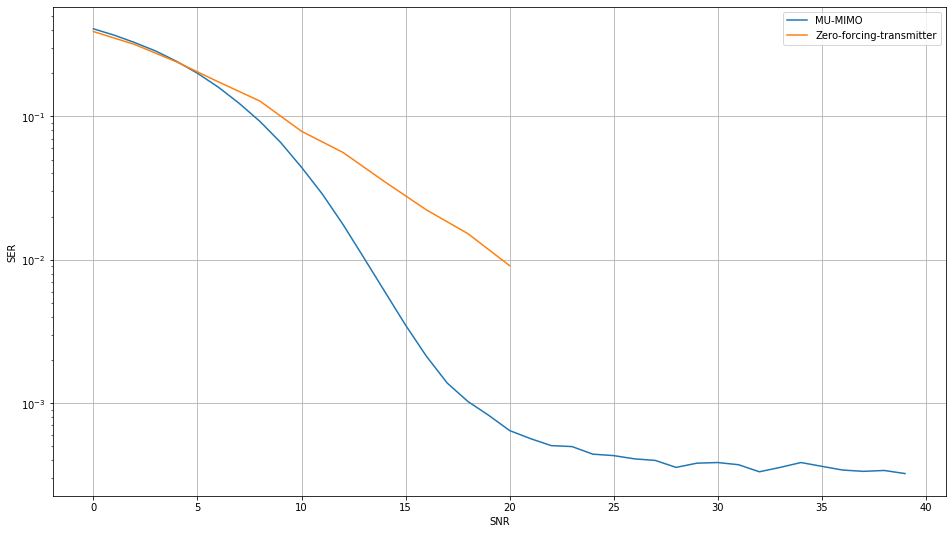

In [55]:
plt.figure(figsize=(16,9))
base=np.array([0.391,0.317, 0.24,0.1744,0.1280, 0.0788,0.056, 0.035, 0.0223, 0.0152, 0.0091])
p1,p2 = plt.semilogy(np.arange(0, 40,1), SER, np.arange(0,21,2), base)
plt.xlabel('SNR')
plt.ylabel('SER')
plt.legend([p1,p2],['MU-MIMO','Zero-forcing-transmitter'])
plt.grid()

import tikzplotlib as tikz
tikz.save('ser_vd.tex')

[4.08585156e-01 3.68770313e-01 3.26864844e-01 2.85632813e-01
 2.42182031e-01 2.00000000e-01 1.60190625e-01 1.23572656e-01
 9.23648437e-02 6.57578125e-02 4.42023437e-02 2.87507812e-02
 1.75812500e-02 1.03070312e-02 6.00312500e-03 3.50078125e-03
 2.12500000e-03 1.38125000e-03 1.02578125e-03 8.21093750e-04
 6.43750000e-04 5.65625000e-04 5.05468750e-04 4.97656250e-04
 4.40625000e-04 4.30468750e-04 4.08593750e-04 3.98437500e-04
 3.56250000e-04 3.81250000e-04 3.85156250e-04 3.71875000e-04
 3.32031250e-04 3.56250000e-04 3.85156250e-04 3.62500000e-04
 3.41406250e-04 3.34375000e-04 3.39062500e-04 3.22656250e-04]


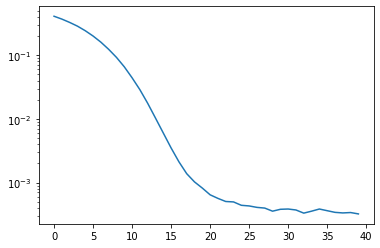

In [56]:
print(SER)

np.savez('mu-mimo-ser.npz',ser=SER)
SER1 = np.load('mu-mimo-ser.npz')['ser']
plt.semilogy(SER1)

In [ ]:

# torch.save({
#             'encoder': encoder.state_dict(),
#             'decoder1': decoder1.state_dict(),
#             'decoder2': decoder2.state_dict(), 
#             }, 'Autoencoder-MU-MIMO')

# encoder = Encoder().to(device)
# decoder = Decoder().to(device)
# tx_opt = Adam(encoder.parameters(), lr = 0.001)
# rx_opt = Adam(decoder.parameters(), lr = 0.008)

# checkpoint = torch.load('Autoencoder-MU-MIMO')
# encoder.load_state_dict(checkpoint['encoder'])
# decoder.load_state_dict(checkpoint['decoder1'])
# decoder.load_state_dict(checkpoint['decoder2'])


